In [31]:
import librosa
import numpy as np
import os
import scipy.fft
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from google.colab import drive
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import seaborn as sns
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pré-processamento de dados
Nesta primeira etapa, normalizamos todos os audios do nosso dataset e carregamos eles para lista audio_data.

In [32]:
# Função para carregar e normalizar áudios com amplitudes entre -1 e 1 (Pré-processamento)
def load_and_normalize_audio(file_path, target_sr=16000, duration=None):
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration, mono=True)
    normalized_audio = librosa.util.normalize(audio)
    return normalized_audio, sr

def process_audio_files(folder_path, target_sr=16000, duration=None):
    audio_data = []  # Lista para armazenar os áudios normalizados
    encoded_labels = []  # Lista para armazenar os rótulos codificados

    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            if file_name.endswith('.wav'):
                file_path = os.path.join(root, file_name)
                normalized_audio, sr = load_and_normalize_audio(file_path, target_sr=target_sr, duration=duration)

                # Extrair o rótulo do nome da pasta pai (classe)
                label = os.path.basename(os.path.dirname(file_path))

                audio_data.append((normalized_audio, sr))  # Adiciona o áudio normalizado e a sua taxa de amostragem à lista
                encoded_labels.append(label)  # Adiciona o rótulo à lista de rótulos codificados

    return audio_data, encoded_labels

folder_path = "/content/drive/MyDrive/NonverbalVocalization"
audio_data, encoded_labels = process_audio_files(folder_path)

## Extraindo Features
Nesta etapa extraimos caracteristicas sobre os espectros de frequências dos nossos sinais por meio de 10 extratores diferentes, cada um dividido em 2, totalizando 20.


In [33]:
def extract_features(audio_data):
    extracted_features = []

    for audio, sr in audio_data:
        features = []
        #FFT
        fft = np.fft.fft(audio)

        fft_magnitude = np.abs(fft)
        fft_magnitude_mean = fft_magnitude.mean()
        fft_magnitude_var = fft_magnitude.var()

        # Zero Crossing Rate
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)[0]
        zero_crossing_rate_mean = zero_crossing_rate.mean()
        zero_crossing_rate_var = zero_crossing_rate.var()

        # Spectral Centroid
        spectral_centroid = librosa.feature.spectral_centroid(y=audio, sr=sr)[0]
        spectral_centroid_mean = spectral_centroid.mean()
        spectral_centroid_var = spectral_centroid.var()

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        spectral_contrast_mean = spectral_contrast.mean()
        spectral_contrast_var = spectral_contrast.var()

        # Mel-Frequency Cepstral Coefficients (MFCCs)
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        mfccs_mean = mfccs.mean()
        mfccs_var = mfccs.var()

        # Chroma Energy Normalized (CENS)
        chroma_cens = librosa.feature.chroma_cens(y=audio, sr=sr)
        chroma_cens_mean = chroma_cens.mean()
        chroma_cens_var = chroma_cens.var()

        # RMS Energy
        rms = librosa.feature.rms(y=audio)[0]
        rms_mean = rms.mean()
        rms_var = rms.var()

        # Tempogram
        tempogram = librosa.feature.tempogram(y=audio, sr=sr)
        tempogram_mean = tempogram.mean()
        tempogram_var = tempogram.var()

        # Spectral Roll-off
        spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
        spectral_rolloff_mean = spectral_rolloff.mean()
        spectral_rolloff_var = spectral_rolloff.var()

        # # Spectral Bandwidth
        # spectral_bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0]
        # spectral_bandwidth_mean = spectral_bandwidth.mean()
        # spectral_bandwidth_var = spectral_bandwidth.var()

        # Spectral Contrast
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=sr)
        spectral_contrast_mean = spectral_contrast.mean()
        spectral_contrast_var = spectral_contrast.var()

        # Spectral Flatness
        spectral_flatness = librosa.feature.spectral_flatness(y=audio)
        spectral_flatness_mean = spectral_flatness.mean()
        spectral_flatness_var = spectral_flatness.var()

        features.append(fft_magnitude_mean)
        features.append(fft_magnitude_var)
        features.append(zero_crossing_rate_mean)
        features.append(zero_crossing_rate_var)
        features.append(spectral_centroid_mean)
        features.append(spectral_centroid_var)
        features.append(spectral_flatness_mean)
        features.append(spectral_flatness_var)
        features.append(spectral_contrast_mean)
        features.append(spectral_contrast_var)
        # features.append(spectral_bandwidth_mean)
        # features.append(spectral_bandwidth_var)
        features.append(spectral_rolloff_mean)
        features.append(spectral_rolloff_var)
        features.append(tempogram_mean)
        features.append(tempogram_var)
        features.append(rms_mean)
        features.append(rms_var)
        features.append(chroma_cens_mean)
        features.append(chroma_cens_var)
        features.append(mfccs_mean)
        features.append(mfccs_var)

        extracted_features.append(features)

    return extracted_features

##Seleção de características com Chi-Quadrado
Nesta etapa, aplicamos o teste do Chi-Quadrado para avaliar a relevância de cada característica em nosso dataset, selecionando as mais significativas para o modelo.






In [34]:
def select_features(features, y) : #Teste do chi2
  bestfeatures = SelectKBest(score_func=chi2, k=20)
  fit = bestfeatures.fit(features,y)
  dfscores = pd.DataFrame(fit.scores_)
  featureScores = pd.concat([dfscores],axis=1)
  featureScores.columns = ['Score']
  print(featureScores.nlargest(20,'Score'))

## Extração de features
Aqui chamamos a função de extração de features e codificamos nosso array de labels, que iniciamente era uma array de strings, com o nome da classe de cada áudio.

In [35]:
features = extract_features(audio_data)
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(encoded_labels) # Converter os rótulos em valores numéricos

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=500
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=480
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=503
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=505
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=510
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=512 is too large for input signal of length=485
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWa

## Classificador Random Forest
Nesta etapa, apresentamos a aplicação do classificador Random Forest. O classificador é treinado e avaliado usando métricas como precisão, recall e F1-score para determinar o desempenho do modelo.

In [36]:
# Normalizar a matriz
scaler = MinMaxScaler()
normalized_matrix = scaler.fit_transform(features)

# Selecionar as melhores features
selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100))
selected_features = selector.fit_transform(normalized_matrix, y_train_encoded)

# Balanceamento de classes usando SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(selected_features, y_train_encoded)

# Dividir o conjunto de treinamento em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
}

# Criar o GridSearchCV para Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(), param_grid_rf, cv=5)
grid_search_rf.fit(X_train, y_train)

# Melhor modelo encontrado pelo GridSearchCV
best_rf_classifier = grid_search_rf.best_estimator_

# Treinar e avaliar o modelo com os melhores parâmetros no conjunto de teste
best_rf_classifier.fit(X_train, y_train)
y_pred_rf = best_rf_classifier.predict(X_test)
print("Results for Random Forest with best parameters:")
print(classification_report(y_test, y_pred_rf, zero_division=1))

Results for Random Forest with best parameters:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59        13
           1       0.69      0.90      0.78        10
           2       0.92      0.80      0.86        15
           3       0.67      0.86      0.75         7
           4       0.75      0.86      0.80         7
           5       0.94      0.94      0.94        18
           6       0.43      0.33      0.38         9
           7       0.91      0.77      0.83        13
           8       0.67      0.67      0.67         9
           9       0.83      0.71      0.77         7

    accuracy                           0.76       108
   macro avg       0.74      0.75      0.74       108
weighted avg       0.77      0.76      0.76       108



##Resultados
Para enxergar melhor os resultados do modelo, plotamos a matriz de confusão

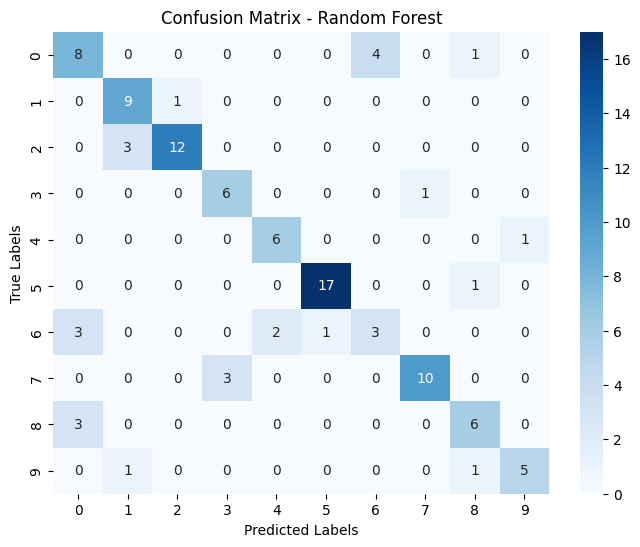

In [37]:
# Calcular a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred_rf)

# Plotar a matriz de confusão usando seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Random Forest')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
